In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('data.csv')

# Feature Engeneering

In [2]:
df = df.drop('Unnamed: 32', axis=1)

In [3]:
df = df.drop('id', axis = 1)

In [4]:
df['diagnosis'] = df['diagnosis'].replace(['M', 'B'], [1,0])

In [5]:
df['BigOrSmall'] = np.where(df['area_mean']>555, 'Big', 'Small')

In [6]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,BigOrSmall
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Big
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Big
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Big
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Small
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Big


In [7]:
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'BigOrSmall'],
      dtype='object')

In [8]:
df = df[['diagnosis', 'radius_mean', 'texture_mean','BigOrSmall', 'smoothness_mean', 'texture_se', 'texture_worst']]

In [9]:
df.head()

,diagnosis,radius_mean,texture_mean,BigOrSmall,smoothness_mean,texture_se,texture_worst
0,1,17.99,10.38,Big,0.11840,0.9053,17.33
1,1,20.57,17.77,Big,0.08474,0.7339,23.41
2,1,19.69,21.25,Big,0.10960,0.7869,25.53
3,1,11.42,20.38,Small,0.14250,1.1560,26.50
4,1,20.29,14.34,Big,0.10030,0.7813,16.67


# Pytorch ANN

We want to predict the diagnosis. And we introduced a new categorical feature BigOrSmall. It will use a reduced dataframe as it is seen above.

1) Divide into categorical e continuous

In [10]:
cat_cols = ['BigOrSmall']
cont_cols = ['radius_mean', 'texture_mean', 'smoothness_mean', 'texture_se', 'texture_worst']
y_col = ['diagnosis']

2) Assign the Categorical type

In [11]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df['BigOrSmall'].head()

0      Big
1      Big
2      Big
3    Small
4      Big
Name: BigOrSmall, dtype: category
Categories (2, object): ['Big', 'Small']

3) Stack into an array the categorical features

In [13]:
BS = df['BigOrSmall'].cat.codes.values
cats = np.stack([BS], 1)

# Convert to tensor
cats = torch.tensor(cats, dtype=torch.int64)

4) Stack into an array the continuous features

In [14]:
conts = np.stack([df[col].values for col in cont_cols], 1)

# Convert to tensor
conts = torch.tensor(conts, dtype=torch.float)

5) Create Label Tensor

In [15]:
y = torch.tensor(df[y_col].values).flatten()

6) Embedding Size

In [16]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1)]

7) Train and test Split

In [17]:
# CODE HERE
b = 569# suggested batch size
t = 300  # suggested test size

cat_train = cats[:b-t]
cat_test = cats[b-t:b]
con_train = conts[:b-t]
con_test = conts[b-t:b]
y_train = y[:b-t]
y_test = y[b-t:b]

8) Tabular Module

In [18]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

7) Instanciate the Model

In [19]:
model = TabularModel(emb_szs, conts.shape[1], 2, [50, 20], p=0.65) # out_sz = 2

In [20]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.65, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.65, inplace=False)
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.65, inplace=False)
    (8): Linear(in_features=20, out_features=2, bias=True)
  )
)

8) Define Loss function and optimizer

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

9) Train the Model

In [22]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.82527632
epoch:  26  loss: 0.53958052
epoch:  51  loss: 0.49031311
epoch:  76  loss: 0.36736631
epoch: 101  loss: 0.28193927
epoch: 126  loss: 0.27715251
epoch: 151  loss: 0.26507416
epoch: 176  loss: 0.22014228
epoch: 201  loss: 0.21375619
epoch: 226  loss: 0.17763563
epoch: 251  loss: 0.17699653
epoch: 276  loss: 0.17265297
epoch: 300  loss: 0.18977384

Duration: 2 seconds


10) Plot the Losses

tensor(0.1898, grad_fn=<NllLossBackward>)


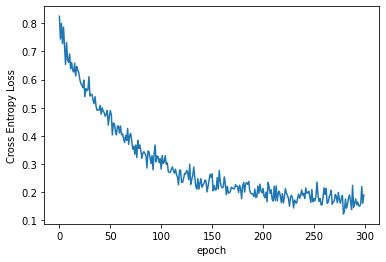

In [23]:
# CODE HERE
plt.plot(range(epochs),losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');
print(losses[-1])

### Evaluate on Test Set

In [24]:
with torch.no_grad():
    y_val = model(cat_test,con_test)
    loss = criterion(y_val,y_test)

# RUN THIS CODE TO COMPARE RESULTS
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.67494678


Lets obtain the accuracy!

In [25]:
rows = 300
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.3360, -0.5690])    0      0   
tensor([ 4.2680, -2.0070])    0      0   
tensor([ 2.5722, -5.9588])    0      0   
tensor([-2.4543,  3.2955])    1      1   
tensor([  5.1016, -10.2323])    0      0   
tensor([-3.4690,  1.6169])    1      1   
tensor([ 1.7432, -2.3684])    0      0   
tensor([ 1.6082, -2.1396])    0      0   
tensor([-4.0682,  1.9223])    1      1   
tensor([0.2699, 1.1710])      1      0   
tensor([-0.3228,  1.1777])    1      0   
tensor([-3.2891,  1.8991])    1      1   
tensor([ 3.3507, -3.3620])    0      0   
tensor([-3.8901,  2.0883])    1      1   
tensor([-1.6349,  1.4571])    1      1   
tensor([ 1.1770, -0.8714])    0      0   
tensor([ 2.9277, -3.9986])    0      0   
tensor([ 1.6590, -0.5759])    0      0   
tensor([ 0.7578, -1.0583])    0      0   
tensor([ 4.4131, -3.1266])    0      0   
tensor([ 3.0584, -2.9737])    0      0   
tensor([ 0.7703, -0.3200])    0      0   
tensor([-1.6683,  1.2470])    1 